# House Prices: Advanced Regression

Kaggle educational [challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) for the BC Machine Learning working group practice.

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.preprocessing import MinMaxScaler

% matplotlib inline

In [2]:
df_raw_train = pd.read_csv('train.csv', index_col='Id')
print('Loaded training data with {} rows and {} columns'.format(
    df_raw_train.shape[0], df_raw_train.shape[1]))

# separate target and input features
y = df_raw_train.SalePrice.values
X_df_raw_train = df_raw_train[[col for col in df_raw_train.columns if col != 'SalePrice']].copy()

X_df_raw_train.head()

Loaded training data with 1460 rows and 80 columns


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [3]:
X_df_raw_test = pd.read_csv('test.csv', index_col='Id')
print('Loaded test data with {} rows and {} columns'.format(
    X_df_raw_test.shape[0], X_df_raw_test.shape[1]))

X_df_raw_test.head()

Loaded test data with 1459 rows and 79 columns


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# this function is awesome! but doesn't render great on GitHub
# pandas_profiling.ProfileReport(df_raw)

### Transform the Training & Test data in the same way

In [5]:
X_df_raw_combined = pd.concat([X_df_raw_train, X_df_raw_test])

# Missing values: get more sophisticated with this later...
X_df_combined = X_df_raw_combined.fillna(0)

# One-hot encoding
X_df_combined_wdummies = pd.get_dummies(X_df_combined)

# Separate training and testing data
X_df = X_df_combined_wdummies.loc[X_df_combined_wdummies.index.isin(X_df_raw_train.index)]
X_df_test = X_df_combined_wdummies.loc[X_df_combined_wdummies.index.isin(X_df_raw_test.index)]
assert X_df.shape[1] == X_df_test.shape[1]  # same number of columns

X = X_df.values
X_test = X_df_test.values

# Scale features
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# Train/Validation split for testing models within the training set
random_state = 42  # constant so y split is same for both
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=random_state)
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_scaled, y, random_state=random_state)

In [6]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)
rf.score(X_val, y_val)  # this is R^2

0.89274787151759083

In [7]:
# y_pred = pd.DataFrame({'Id': X_df_test.index, 'SalePrice': rf.predict(X_test)})
# y_pred.to_csv('submission.csv', index=False)

## Evaluation Metric: Root Mean Squared Log Error
RMSLE = $\sqrt{\frac{1}{N} \sum \left[ \ln(1 + y_{true}) - \ln(1 + y_{pred}) \right] ^2 }$

I found a few ways to apply this metric for scoring. Calculating it from the square root of the `mean_squared_log_error` function, or using the built in `neg_mean_squared_log_error` scikit-learn "scorer" in cross-validation, which still requires a sign change and the square root to be applied... I think the best way is the creation of the `rmsle_scorer` which I can reuse in different runs of cross-validation.

In [8]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))
    
rmsle_score = make_scorer(rmsle)

In [9]:
y_pred = rf.predict(X_val)
score = rmsle(y_val, y_pred)
score

0.14405701982111993

In [10]:
negMSLE_scores = cross_val_score(RandomForestRegressor(n_estimators=100), cv=5,
                                 X=X, y=y, n_jobs=-1, scoring='neg_mean_squared_log_error')

RMSLE_scores = np.sqrt(-1*negMSLE_scores)
RMSLE_scores.mean()

0.14837650240699632

In [11]:
RMSLE_scores = cross_val_score(RandomForestRegressor(n_estimators=100), cv=5,
                               X=X, y=y, n_jobs=-1, scoring=rmsle_score)
RMSLE_scores.mean()

0.14837650240699632

In [12]:
lm = Ridge()
lm.fit(X_train, y_train)
lm.score(X_val, y_val)  # R^2

0.88674136159561212

In [13]:
RMSLE_scores = cross_val_score(Ridge(), cv=5, X=X, y=y, n_jobs=-1, scoring=rmsle_score)
RMSLE_scores.mean()

0.16687314830918382

In [14]:
RMSLE_scores = cross_val_score(Ridge(), cv=5, X=X_scaled, y=y, n_jobs=-1, scoring=rmsle_score)
RMSLE_scores.mean()  # just a little better

0.16267012168084363

In [15]:
lm = Ridge()
lm.fit(X_train_scaled, y_train)

y_train_pred = lm.predict(X_train_scaled)
rmsle_on_training = rmsle(y_train, y_train_pred)
r2_on_training = lm.score(X_train_scaled, y_train)

y_val_pred = lm.predict(X_val_scaled)
rmsle_on_val = rmsle(y_val, y_val_pred)
r2_on_val = lm.score(X_val_scaled, y_val)

print('Training data:   RMSLE = {:.4f}, R^2 = {:.4f}'.format(rmsle_on_training, r2_on_training))
print('Validation data: RMSLE = {:.4f}, R^2 = {:.4f}'.format(rmsle_on_val, r2_on_val))

Training data:   RMSLE = 0.1133, R^2 = 0.9211
Validation data: RMSLE = 0.1647, R^2 = 0.8800


In [16]:
lm = Ridge(alpha=10)
lm.fit(X_train_scaled, y_train)

y_train_pred = lm.predict(X_train_scaled)
rmsle_on_training = rmsle(y_train, y_train_pred)
r2_on_training = lm.score(X_train_scaled, y_train)

y_val_pred = lm.predict(X_val_scaled)
rmsle_on_val = rmsle(y_val, y_val_pred)
r2_on_val = lm.score(X_val_scaled, y_val)

print('Training data:   RMSLE = {:.4f}, R^2 = {:.4f}'.format(rmsle_on_training, r2_on_training))
print('Validation data: RMSLE = {:.4f}, R^2 = {:.4f}'.format(rmsle_on_val, r2_on_val))

Training data:   RMSLE = 0.1239, R^2 = 0.8892
Validation data: RMSLE = 0.1637, R^2 = 0.8595


In [17]:
lm = Lasso(max_iter=1e3, alpha=100)
lm.fit(X_train_scaled, y_train)

y_train_pred = lm.predict(X_train_scaled)
rmsle_on_training = rmsle(y_train, y_train_pred)
r2_on_training = lm.score(X_train_scaled, y_train)

y_val_pred = lm.predict(X_val_scaled)
rmsle_on_val = rmsle(y_val, y_val_pred)
r2_on_val = lm.score(X_val_scaled, y_val)

print('Training data:   RMSLE = {:.4f}, R^2 = {:.4f}'.format(rmsle_on_training, r2_on_training))
print('Validation data: RMSLE = {:.4f}, R^2 = {:.4f}'.format(rmsle_on_val, r2_on_val))

Training data:   RMSLE = 0.1172, R^2 = 0.9122
Validation data: RMSLE = 0.1435, R^2 = 0.8931


In [18]:
# y_pred = pd.DataFrame({'Id': X_df_test.index, 'SalePrice': lm.predict(X_test_scaled)})
# y_pred.to_csv('submission.csv', index=False)

In [19]:
# svm = SVR(C=100)
# svm.fit(X_train_scaled, y_train)

# y_train_pred = svm.predict(X_train_scaled)
# rmsle_on_training = rmsle(y_train, y_train_pred)
# r2_on_training = svm.score(X_train_scaled, y_train)

# y_val_pred = svm.predict(X_val_scaled)
# rmsle_on_val = rmsle(y_val, y_val_pred)
# r2_on_val = svm.score(X_val_scaled, y_val)

# print('Training data:   RMSLE = {:.4f}, R^2 = {:.4f}'.format(rmsle_on_training, r2_on_training))
# print('Validation data: RMSLE = {:.4f}, R^2 = {:.4f}'.format(rmsle_on_val, r2_on_val))

## Feature Importances & Weights

In [20]:
rf = RandomForestRegressor(n_estimators=1000)
_ = rf.fit(X, y)

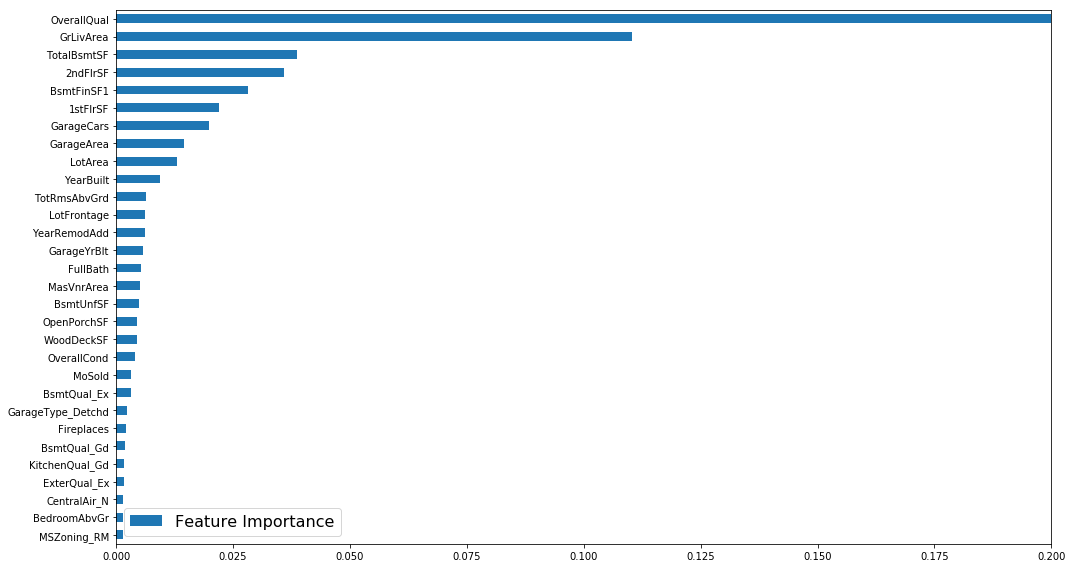

In [21]:
importance = pd.DataFrame({'Feature': X_df.columns.values, 'Feature Importance': rf.feature_importances_})
importance.index = importance.pop('Feature')
importance.sort_values(by='Feature Importance', ascending=True, inplace=True)
ax = importance.iloc[-30:].plot.barh(figsize=[15, 8])
ax.set_xlim([0, 0.2])
ax.set_ylabel('')
ax.legend(fontsize=16)
plt.tight_layout()

In [22]:
lm = Ridge()
_ = lm.fit(X_scaled, y)

In [23]:
lm = Lasso(max_iter=1e3, alpha=100)
_ = lm.fit(X_scaled, y)

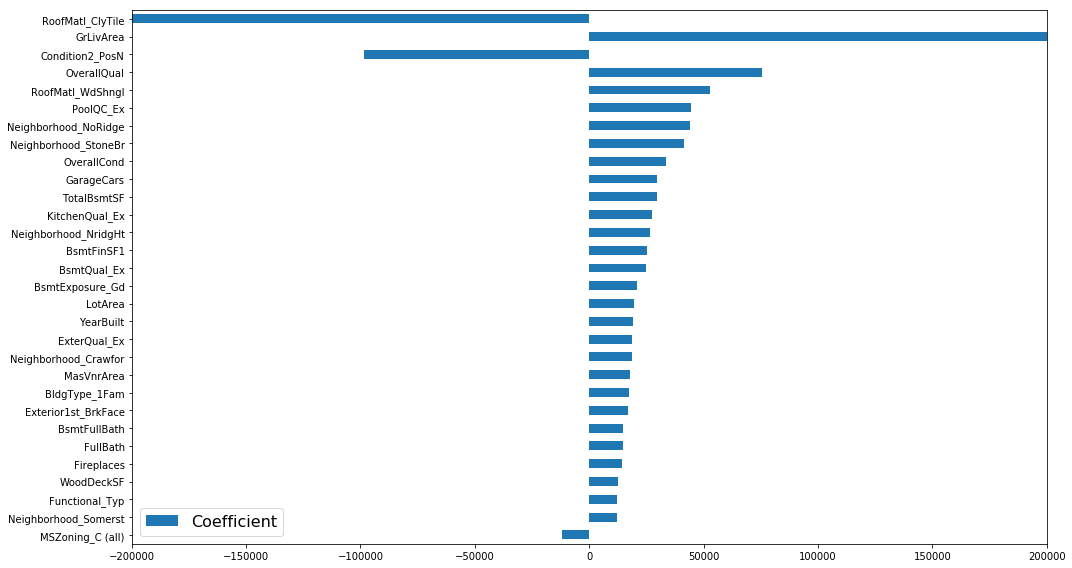

In [24]:
weight = pd.DataFrame({'Feature': X_df.columns.values, 'Coefficient': lm.coef_})
weight.index = weight.pop('Feature')
weight = weight.reindex(weight.Coefficient.abs().sort_values(ascending=True).index)
ax = weight.iloc[-30:].plot.barh(figsize=[15, 8])
ax.set_xlim([-2e5, 2e5])
ax.set_ylabel('')
ax.legend(fontsize=16)
plt.tight_layout()

In [25]:
weight

,Coefficient
Feature,
Exterior2nd_BrkFace,0.000000
Foundation_Slab,-0.000000
Foundation_Stone,0.000000
Foundation_Wood,-0.000000
BsmtQual_0,-0.000000
BsmtQual_Fa,0.000000
BsmtQual_Gd,0.000000
BsmtCond_0,-0.000000
BsmtCond_Fa,-0.000000


## Feature Engineering

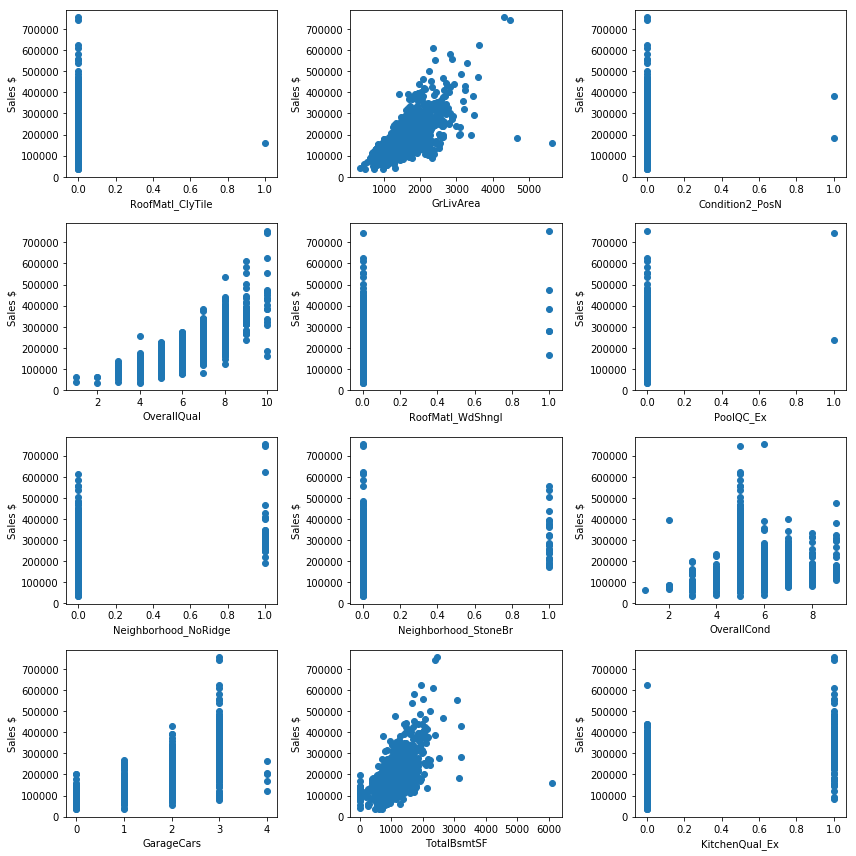

In [26]:
top_features = weight[-12:].index.values[-1::-1]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=[12,12])
axes.ravel()
for ax, col in zip(axes.ravel(), top_features):
    ax.scatter(X_df[col], y)
    ax.set_xlabel(col)
    ax.set_ylabel('Sales $')
fig.tight_layout()

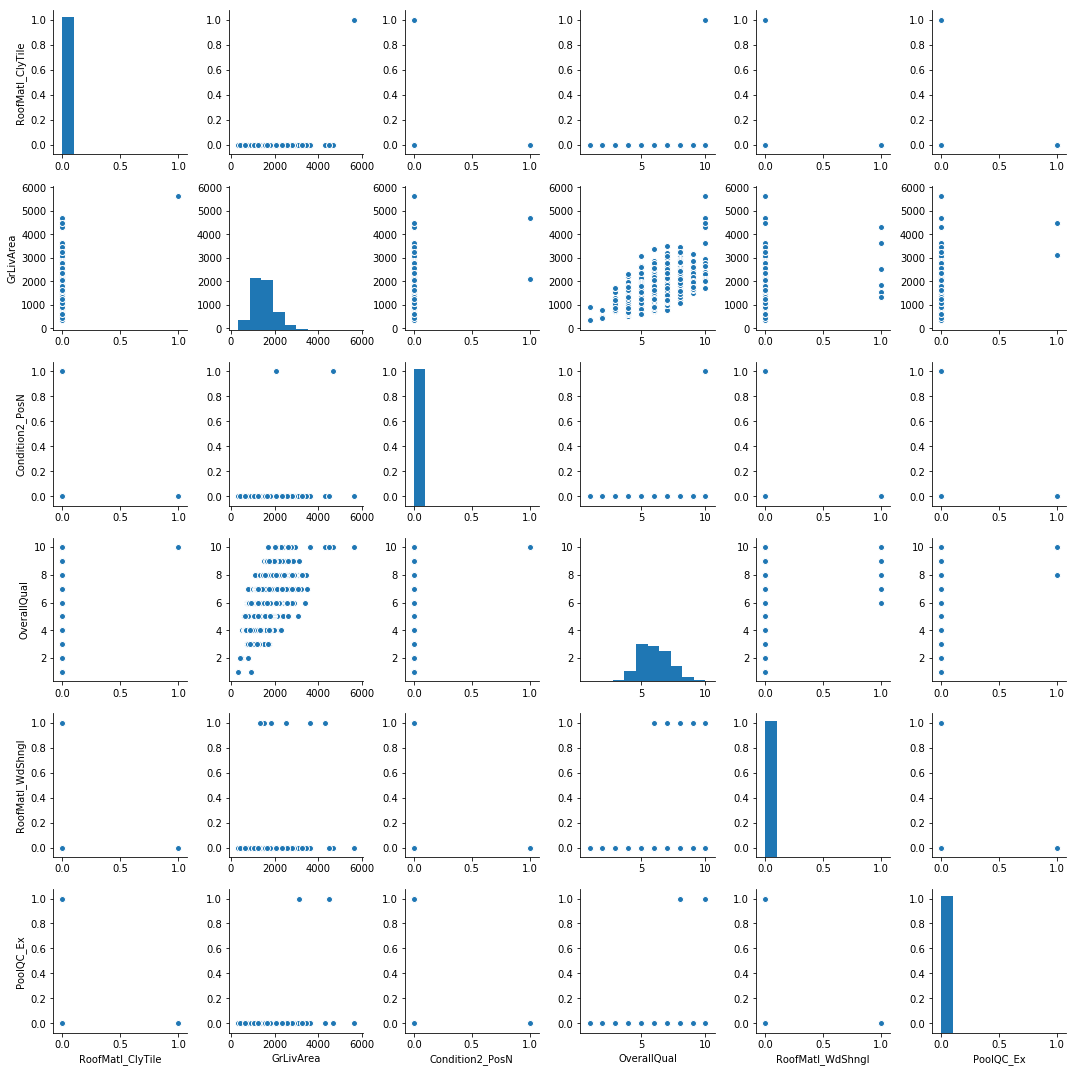

In [27]:
top_features = weight[-6:].index.values[-1::-1]
sns.pairplot(X_df[top_features]);

### Garage features...

In [28]:
df_raw_train.columns[df_raw_train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [29]:
df_raw_train.GarageType.fillna('NA', inplace=True)

In [30]:
df_raw_train.groupby('GarageType').OverallQual.count()

GarageType
2Types       6
Attchd     870
Basment     19
BuiltIn     88
CarPort      9
Detchd     387
NA          81
Name: OverallQual, dtype: int64

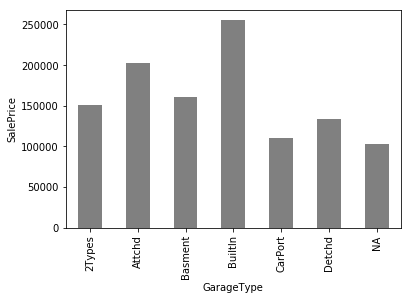

In [31]:
ax = df_raw_train.groupby('GarageType').SalePrice.mean().plot.bar(color='gray')
ax.set_ylabel('SalePrice');

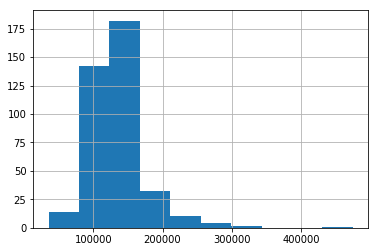

In [32]:
df_raw_train.loc[df_raw_train.GarageType == 'Detchd'].SalePrice.hist();

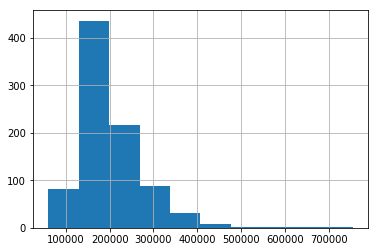

In [33]:
df_raw_train.loc[df_raw_train.GarageType == 'Attchd'].SalePrice.hist();

In [34]:
df_raw_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [35]:
df_raw_train.RoofMatl.fillna('NA', inplace=True)
df_raw_train.groupby('RoofMatl').OverallQual.count()

RoofMatl
ClyTile       1
CompShg    1434
Membran       1
Metal         1
Roll          1
Tar&Grv      11
WdShake       5
WdShngl       6
Name: OverallQual, dtype: int64

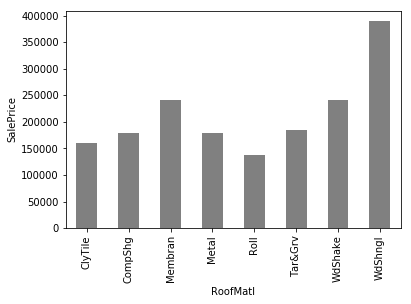

In [36]:
ax = df_raw_train.groupby('RoofMatl').SalePrice.mean().plot.bar(color='gray')
ax.set_ylabel('SalePrice');

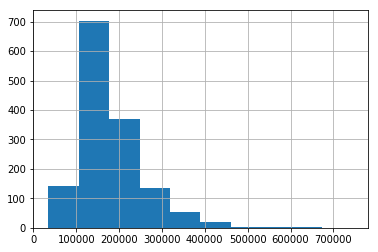

In [37]:
df_raw_train.loc[df_raw_train.RoofMatl == 'CompShg'].SalePrice.hist();

In [38]:
df_raw_train[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']].sample(10)

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
Id,,,,,
664,Detchd,1974.0,RFn,TA,TA
1040,Attchd,1970.0,Unf,TA,TA
844,NA,NaN,NaN,NaN,NaN
319,Attchd,1993.0,RFn,TA,TA
666,Attchd,2000.0,RFn,TA,TA
1157,Attchd,1965.0,RFn,TA,TA
154,Attchd,1960.0,RFn,TA,TA
1372,BuiltIn,1955.0,RFn,TA,TA
1086,Attchd,1992.0,Unf,TA,TA
